In [ ]:
import os, cv2, json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.models import load_model

In [ ]:
train = pd.read_csv("/content/train.csv")

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_validate, y_train, y_test = train_test_split(train, train.label,train_size=0.8,random_state=42,stratify=train.label)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_validate = df_validate.reset_index(drop=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Now you can access files from Google Drive like this:
dataset_path = '/content/drive/My Drive/Tomato_images/Tomato_images'  # Update with your folder's path


Mounted at /content/drive


In [ ]:
# Main parameters
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(train)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train)*0.2 / BATCH_SIZE
EPOCHS =60 #
IMG_WIDTH= 256
IMG_HEIGHT= 256
train_dir = '/content/drive/My Drive/Tomato_images/Tomato_images'

In [ ]:
df_train.label = df_train.label.astype('str')
df_validate.label = df_validate.label.astype('str')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               rotation_range = 180,
                               vertical_flip = True,
                               horizontal_flip = True)
# our train_datagen generator will use the following transformations on the images
validation_datagen = ImageDataGenerator(rescale=1./255)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator with rescaling and resizing
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    train_dir,
                                                    target_size=(299,299),
                                                    batch_size=32,
                                                    x_col='img',
                                                    y_col='label',
                                                    class_mode = 'categorical')

# generator = ImageDataGenerator(*args).flow_from_dataframe(dataframe, directory, target_size,
# batch_size, x_col, y_col, class_mode)
# your dataframe shoudl be in the format such that x_col = features, y_col = class/label
# binary class mode since output is either 0(dog) or 1(cat)

validation_generator = validation_datagen.flow_from_dataframe(df_validate,
                                                   train_dir,
                                                    target_size=(299,299),
                                                    x_col='img',
                                                    y_col='label',
                                                    class_mode='categorical',
                                                  batch_size=32)

Found 3039 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 11489 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  warnings.warn(


Found 811 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2821 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Assuming IMG_WIDTH and IMG_HEIGHT are defined elsewhere
IMG_WIDTH = 299  # Example value, update as needed
IMG_HEIGHT = 299  # Example value, update as needed

def create_model():
    # Load the base InceptionV3 model with pre-trained ImageNet weights
    inception_base = InceptionV3(
        weights='imagenet',  # Use pre-trained ImageNet weights
        include_top=False,
        input_shape=(299,299, 3),
        pooling='avg'
    )

    # Add the top layers (fully connected layers)
    model = Sequential([
        inception_base,
        Dense(10, activation='softmax')  # Assuming you have 10 classes
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create model and show summary
model = create_model()
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,823,274 (83.25 MB)

 Trainable params: 21,788,842 (83.12 MB)

 Non-trainable params: 34,432 (134.50 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,823,274 (83.25 MB)

 Trainable params: 21,788,842 (83.12 MB)

 Non-trainable params: 34,432 (134.50 KB)

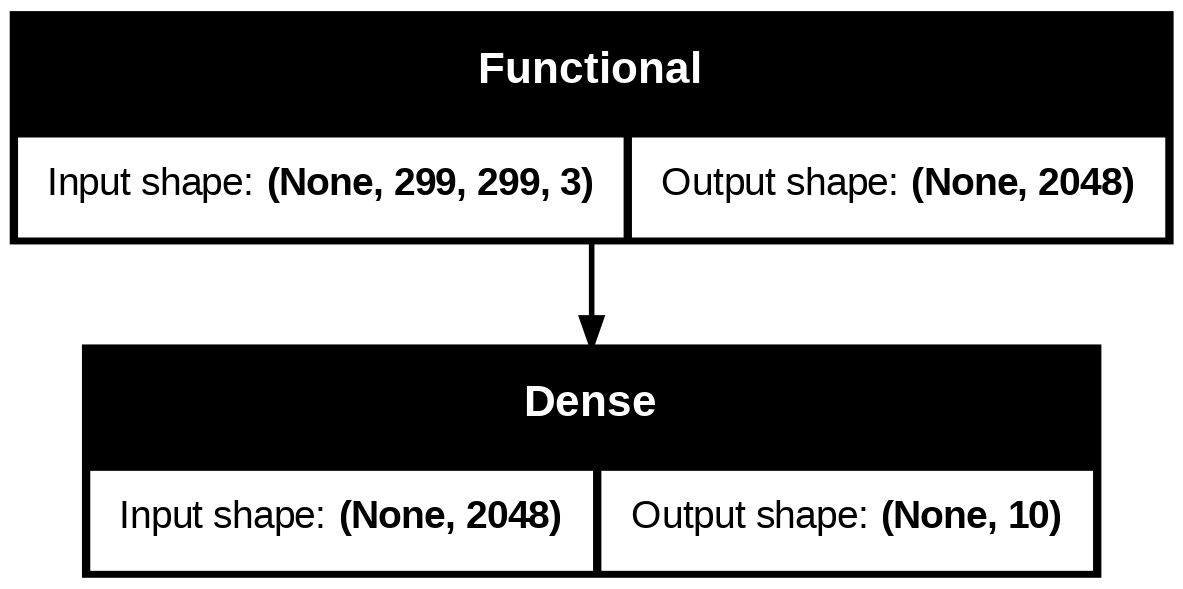

In [ ]:
from keras.utils import plot_model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

In [ ]:
model_save = ModelCheckpoint('./InceptionV3_256.keras',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_loss',
                             mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001,
                           patience=10, mode='min', verbose=1,
                           restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=2, min_delta=0.001,
                              mode='min', verbose=1)

EPOCHS = 10

history = model.fit(
    train_generator,
    steps_per_epoch=int(STEPS_PER_EPOCH),  # Make sure steps_per_epoch is an integer
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=int(VALIDATION_STEPS),  # Make sure validation_steps is an integer
    callbacks=[model_save, early_stop, reduce_lr]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 95/908 ━━━━━━━━━━━━━━━━━━━━ 7:21:15 33s/step - accuracy: 0.6989 - loss: 0.9330

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 19.41228, saving model to ./InceptionV3_256.keras
908/908 ━━━━━━━━━━━━━━━━━━━━ 3508s 4s/step - accuracy: 0.7785 - loss: 0.6815 - val_accuracy: 0.1147 - val_loss: 19.4123 - learning_rate: 0.0010
Epoch 2/10
 95/908 ━━━━━━━━━━━━━━━━━━━━ 7:17:45 32s/step - accuracy: 0.9008 - loss: 0.3020
Epoch 2: val_loss improved from 19.41228 to 3.29127, saving model to ./InceptionV3_256.keras
908/908 ━━━━━━━━━━━━━━━━━━━━ 3333s 4s/step - accuracy: 0.9048 - loss: 0.2870 - val_accuracy: 0.4797 - val_loss: 3.2913 - learning_rate: 0.0010
Epoch 3/10
 95/908 ━━━━━━━━━━━━━━━━━━━━ 7:21:34 33s/step - accuracy: 0.9394 - loss: 0.1831
Epoch 3: val_loss improved from 3.29127 to 3.10344, saving model to ./InceptionV3_256.keras
908/908 ━━━━━━━━━━━━━━━━━━━━ 3306s 4s/step - accuracy: 0.9386 - loss: 0.1866 - val_accuracy: 0.6375 - val_loss: 3.1034 - learning_rate: 0.0010
Epoch 4/10
 95/908 ━━━━━━━━━━━━━━━━━━━━ 7:22:21 33s/step - accuracy: 0.9434 - loss: 0.1864
Epoch 4: val_loss impr